### Brain image modeling with tensor2tensor and Kubeflow

Here's a quick example of using the [image transformer 2d model](https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/models/image_transformer_2d.py#L38) from the [tensor2tensor](https://github.com/tensorflow/tensor2tensor) library to do a little modeling of mouse brain tissue images obtained via the [Allen Brain Institute](https://alleninstitute.org/) [API](http://help.brain-map.org/display/api/Downloading+an+Image).

For this experiment I used [Kubeflow](https://github.com/kubeflow/kubeflow) deployed on a Kubernetes cluster running on Google Container Engine.

#### Dependencies

In [1]:
import math
import os
import logging
import shutil

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas

import tensorflow as tf

from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()
Modes = tf.estimator.ModeKeys

from tk.util import hack_dict_to_cli_args
from tk import experiment
from tk import util

from tensor2tensor.utils import trainer_lib
from tensor2tensor import problems
from tensor2tensor.utils import registry
from tensor2tensor.data_generators import allen_brain
from tensor2tensor.data_generators import allen_brain_utils

from tensorboard.backend.event_processing import event_file_loader
from protobuf_to_dict import protobuf_to_dict

logging.getLogger().setLevel(logging.INFO)

from tk.util import hack_dict_to_cli_args
from tk import experiment
from tk import util

%matplotlib inline

Instructions for updating:
Use the retry module or similar alternatives.


In [56]:

def _event_dict_list_from_events_file(event_file_path):
    """Given an event file path, load the event data.
    
    Args:
        event_file_path (str): A path to a TensorFlow events.out* file.
    """
    loader = event_file_loader.EventFileLoader(event_file_path)
    events = []
    for event in loader.Load():
      events.append(event)

    output_events = []

    for thing in events:
        d = protobuf_to_dict(thing)

        output_event = {}
        if "wall_time" in d:
            output_event["wall_time"] = d["wall_time"]
        if "step" in d:
            output_event["step"] = d["step"]
        if "summary" in d.keys():
            values = {}
            for value in d["summary"]["value"]:
                if "simple_value" in value.keys():
                    output_event[value["tag"]] = value["simple_value"]

        if "loss" in output_event:
            output_events.append(output_event)
    
    return output_events


def _event_data_for_comparison(comparison_root, events_subdir_query="*/output/events.out*"):
    """Given root dir path for comparison, load all event data beneath.
    
    Args:
        comparison_root (str): The root path beneath which comparison logs and
            events are being stored.
        events_subdir_query (str): The file path pattern to use to locate event
            files beneath `comparison_root`.
    """
    event_data = []
    tf.logging.info("Identifying event files in experiment subdirectories...")
    paths = tf.gfile.Glob(os.path.join(comparison_root, events_subdir_query))

    for i, experiment in enumerate(paths):
        tf.logging.info("Processing experiment events (%s of %s)" % (i + 1, len(paths)))
        event_list = _event_dict_list_from_events_file(experiment)
        event_dict = {"source_path": experiment,
                      "events": event_list}

        event_data.append(event_dict)
    tf.logging.info("Finished loading event data for comparison.")
    return event_data


def show_experiment_loss(experiments_data):
    """Given a collection of TensorFlow events data, display labeled loss plots.
    
    Args:
        experiments_data (list): A list of event data dictionaries.
    """
    
    plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    for i, experiment_data in enumerate(experiments_data):
        wall_times = [event["wall_time"] for event in experiment_data["events"]]
        minwt = min(wall_times)
        relative_times = [wt - minwt for wt in wall_times]
        losses = [event["loss"] for event in experiment_data["events"]]
        autocorr = math.floor(pandas.Series(losses).autocorr()*1000)/1000
        tag = experiment_data["source_path"].split("/")[-2]
        plt.plot(relative_times, losses, label="%s, ac=%s" % (tag, autocorr))

    plt.legend()
    plt.show()


In [39]:

def infer(predictions):
    """Produce a predicted image using argmax of model-generated logits.
    
    Args:
        predictions (tf.Tensor): A 3-D tensor of logits.
    """
    p = predictions.numpy()
    x_max = p.shape[1] # X-position in image
    y_max = p.shape[2] # Y-position in image
    c_max = p.shape[3] # Color channel (r,g,b)

    # The image we will populate
    image = np.zeros((1, x_max, y_max, c_max), dtype=np.uint8)

    batch_idx = 0

    for x in range(0, x_max):
        for y in range(0, y_max):
            for c in range(0, c_max):
                # Get the index of the greatest value in p[0][x][y][c]
                val = np.argmax(p[0][x][y][c])
                image[batch_idx][x][y][c] = np.uint8(np.argmax(p[0][x][y][c]))
    return image[0]


def _predict_ith(offset, ckpt_path, dataset, model, input_dim=8, output_dim=32):
    """Apply model to input obtained from dataset modulo offset.
    
    Args:
        offset (int): The offset within `dataset` where we will extract an example.
        ckpt_path (str): The path from which checkpoints will be loaded.
        dataset (`obj`): A tf.data dataset object.
        model (`obj`): A tensor2tensor model object loaded from the registry.
    """

    with tfe.restore_variables_on_create(ckpt_path):
      for count, example in enumerate(tfe.Iterator(dataset)):
          if count > offset:
            break
      fig=plt.figure(figsize=(8, 8))
      example["inputs"] = tf.reshape(example["inputs"], [1, input_dim, input_dim, 3])
      fig.add_subplot(1, 3, 1)
      plt.imshow(example["inputs"].numpy()[0])
      fig.add_subplot(1, 3, 2)
      example["targets"] = tf.reshape(example["targets"], [1, output_dim, output_dim, 3])
      plt.imshow(example["targets"].numpy()[0])
      example["targets"] = tf.reshape(tf.zeros((1, output_dim, output_dim, 3), dtype=np.uint8),
                                      [1, output_dim, output_dim, 3])
      predictions, _ = model(example)
      fig.add_subplot(1,3,3)
      plt.imshow(infer(predictions))
      plt.show()


In [40]:
def patchwise_infer(input_image, ckpt_path, target_shape, input_stride=8,
                    target_stride=32, offset=0):
    """Given a small image, infer a large image using non-overlapping patches.
    
    Args:
        input_image (np.Array): An array of image data.
        ckpt_path (str): The path where checkpoint data is stored.
        target_shape (tuple): The shape of the target to infer.
    """
    
    target_image = np.zeros(target_shape, dtype=np.uint8)

    input_shape = np.shape(input_image)

    upscale_factor = target_stride / input_stride

    with tfe.restore_variables_on_create(ckpt_path):

        x_index_max = input_shape[0] // input_stride
        for x_index in range(0, x_index_max):
            
            tf.logging.info("processing row %s of %s" % (
                x_index, x_index_max))

            x_offset_toggle = 0
            if x_index == 1:
                x_offset_toggle = 1

            for y_index in range(0, input_shape[1] // input_stride):

                example = {}
                
                y_offset_toggle = 0
                if y_index == 1:
                    y_offset_toggle = 1

                input_x_start = x_index * input_stride - offset * x_offset_toggle
                input_x_end = input_x_start + input_stride
                input_y_start = y_index * input_stride - offset * y_offset_toggle
                input_y_end = input_y_start + input_stride

                input_patch = input_image[input_x_start:input_x_end,
                                          input_y_start:input_y_end]

                source_reshape = [1, input_stride, input_stride, 3]
                example["inputs"] = tf.reshape(input_patch, source_reshape)

                upscale_offset = offset * upscale_factor
                target_x_start = int(math.floor(x_index * target_stride - upscale_offset * x_offset_toggle))
                target_y_start = int(math.floor(y_index * target_stride - upscale_offset * y_offset_toggle))
                target_x_end = target_x_start + target_stride
                target_y_end =  target_y_start + target_stride

                zero_target = tf.zeros((1, target_stride, target_stride, 3),
                                       dtype=np.uint8)
                #zero_target = target_image[target_x_start:target_x_end,
                #                           target_y_start:target_y_end]
                target_reshape = [1, target_stride, target_stride, 3]
                example["targets"] = tf.reshape(zero_target, target_reshape)

                predictions, _ = model(example)

                prediction = infer(predictions)

                try:
                  target_image[target_x_start:target_x_end,
                               target_y_start:target_y_end] = prediction

                except Exception as e:
                    tf.logging.info("Ran out of space in target, skipping...")

    return target_image


In [48]:

def _stage(local_app_root, remote_app_root):
    """Stage data from `local_app_root` to `remote_app_root`.
    
    Args:
        local_app_root (str): Directory path on local FS.
        remote_app_root (str): Directory path on remote FS.
    """
    
    if not os.path.exists(local_app_root):
        raise ValueError("Can't stage from a non-existent source, "
                         "saw %s" % local_app_root)

    shutil.copytree(local_app_root, remote_app_root)


def _configure_experiment(base_name, num_gpu_per_worker=1,
                          problem="img2img_allen_brain_dim8to32",
                          model="img2img_transformer",
                          hparams_set="img2img_transformer2d_tiny",
                          batch_size=4,
                          num_steps=100000,
                          num_workers=0,
                          num_ps=0,
                          ps_gpu=1):
    """Wrapper to construct args object and produce job scripts.

    Args:
        base_name (str): The base name to be used to identify the experiment.
    """

    app_root = "/mnt/nfs-east1-d/work/tk"
    
    output_dir = os.path.join(app_root, "output")

    job_name = util.generate_job_name(base_name)

    train_args = {
        "problem": problem,
        "model": model,
        "hparams_set": hparams_set,
        "data_dir": "/mnt/nfs-east1-d/data",
        "output_dir": output_dir,
        "train_steps": num_steps,
        "schedule": "train",
        "profile": False,
        "log_device_placement": False,
        "worker_gpu": num_gpu_per_worker,
        "ps_gpu": ps_gpu,
        "save_checkpoints_secs": 1800,
        "dbgprofile": False, # Saves profiling timelines, viewable in chrome://tracing
        "ssd_mount_path": "/mnt/disks/ssd0",
        "worker_gpu_memory_fraction": 0.95,
        "hparams": "'batch_size=%s'" % batch_size
    }

    args = {
        "job_name": job_name,
        "volume_claim_id": "nfs-east1-d",
        "app_root": app_root,
        "gcp_project": "foo",
        "namespace": "kubeflow",
        "image": "tensorflow/tensorflow:latest-gpu",
        "smoke": True,
        "batch": False,
        "train_args": train_args,
        "cpu": 7,
        "memory": "40Gi",
        "num_gpu": num_gpu_per_worker,
        
        # DEV
        "master_gpu": num_gpu_per_worker,
        "ps_gpu": ps_gpu,
        "worker_gpu": num_gpu_per_worker,
        # --

        "num_local_ssd": 1,
        "no_wait": True,
        "num_worker_replicas": num_workers,
        "num_ps_replicas": num_ps,
        "selector_labels": {
          "cloud.google.com/gke-nodepool": "train-gpu-preemptible-%sx-hm" % num_gpu_per_worker,
          "cloud.google.com/gke-accelerator": "nvidia-tesla-k80"
        }
    }

    local_app_root = args["app_root"]

    testing_storage_base = "/mnt/nfs-east1-d/comparisons/%s" % base_name
    
    remote_app_root = "%s/%s" % (testing_storage_base,
                                 args["job_name"])

    output_dir_root = "gs://kubeflow-rl-checkpoints/comparisons/%s" % base_name
    
    # Put training checkpoints in a folder like so:
    # gs://kubeflow-rl-checkpoints/comparisons/[exp base name]/[job id]/output/
    args["train_args"]["output_dir"] = os.path.join(output_dir_root,
                                                    args["job_name"],
                                                    "output")
    
    for job_type in ["master", "ps"]:
        
        with open(os.path.join(local_app_root, "%s-job.sh" % job_type), "w") as f:
          f.write("ls /mnt\n")
          f.write("mkdir /tmp/deps")
          #f.write("tar -xzf %s/deps.tgz /tmp/deps\n" % remote_app_root")
          f.write("cp -r /mnt/nfs-east1-d/data/* /mnt/ssd0/\n")
          f.write("pip install -e %s/vendor/tensor2tensor\n" % remote_app_root)
          f.write("pip install -e %s\n" % remote_app_root)
          f.write("nvidia-smi\n")
          f.write("python -c 'from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())'\n")
          f.write("echo ${TF_CONFIG}\n")
          f.write("cd %s\n" % remote_app_root)
          cmd = ["python", "-m", "tk.experiment"]

          cmd.extend(hack_dict_to_cli_args(args["train_args"]))
          f.write(" ".join(cmd) + "\n")
          f.write("nvidia-smi\n")
          logging.info(local_app_root)
    
    _stage(local_app_root, remote_app_root)
    args["app_root"] = remote_app_root
    args["batch"] = True

    return args


#### Setup

Here we'll be using a Kubeflow cluster configured with NFS with the latter mounted at /mnt/nfs-east1-d. To replicate this example you'll need to deploy something similar.

#### Raw data

First, let's check out an example of the data we're working with. The following will download a 4x down-sampled saggital cross-section image of a mouse brain - from here on we'll be using mouse brain images obtained via the Allen Institute API.

In [16]:
!wget http://api.brain-map.org/api/v2/image_download/102173175?downsample=4 \
    -O /tmp/example.jpg

--2018-08-31 18:30:59--  http://api.brain-map.org/api/v2/image_download/102173175?downsample=4
Resolving api.brain-map.org (api.brain-map.org)... 63.237.233.29
Connecting to api.brain-map.org (api.brain-map.org)|63.237.233.29|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://api.brain-map.org/cgi-bin/imageservice?mime=1&path=/external/mouse/prod1/0500178340/0500178340.aff&left=256&top=24896&width=735&height=486&downsample=4 [following]
--2018-08-31 18:30:59--  http://api.brain-map.org/cgi-bin/imageservice?mime=1&path=/external/mouse/prod1/0500178340/0500178340.aff&left=256&top=24896&width=735&height=486&downsample=4
Reusing existing connection to api.brain-map.org:80.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘/tmp/example.jpg’

/tmp/example.jpg        [  <=>               ]  48.28K   218KB/s    in 0.2s    

2018-08-31 18:31:00 (218 KB/s) - ‘/tmp/example.jpg’ saved [49435]



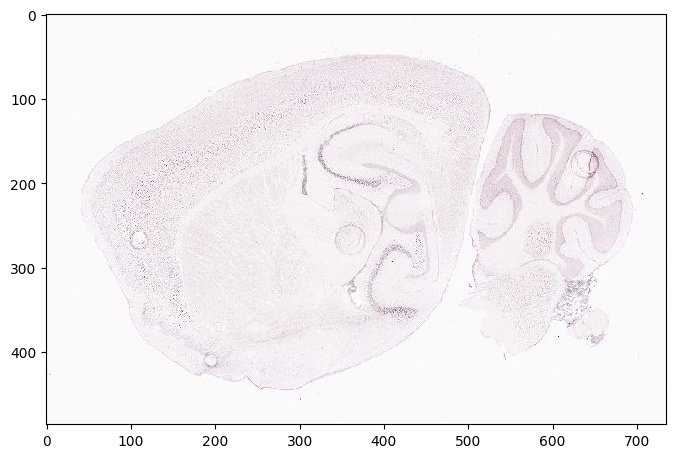

In [17]:
img = Image.open("/tmp/example.jpg")
img = np.float32(img)
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.uint8(img))

Image credit: Allen Brain Institute

#### t2t problem and examples

You can read the details of the tensor2tensor Problem definition for this example [here](https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/data_generators/allen_brain.py#L262) and more generally about t2t Problem objects [here](https://github.com/tensorflow/tensor2tensor/blob/master/docs/new_problem.md).

If you're interested in take a look at what the input/output image pairs look like that we'll be feeding to our model during training, skip ahead to the qualitative analysis portion of the following section!

In [6]:
problem_name = "img2img_allen_brain_dim8to32"

#### Single-machine training

Toward training our model we'll start by exploring what batch sizes can work with our hardware, then examine the loss curves for each experiment to see increased stability with increasing effective batch sizes (as we'd expect). Following that, we'll take a (qualitative) look at how our model is performing with a long run using this batch size and four GPUs within a single machine.

##### Batch size experiment

How high can we push the batch size without crashing? Let's find out!

In [38]:
for bsize in [1, 4, 16, 24, 32]:
    args = _configure_experiment("allen-b%s" % bsize,
                                 problem=problem_name,
                                 num_gpu_per_worker=1,
                                 batch_size=bsize,
                                 num_steps=100)
    job = experiment.T2TExperiment(**args)
    job.run()

In [52]:
# By examining the checkpoint directories for each of those runs we can see only batch sizes of 
# 1, 4, #and 16 were able to complete 100 training steps without crashing.

!gsutil ls gs://kubeflow-rl-checkpoints/comparisons/allen-b*/*/ | grep ckpt-100.meta

gs://kubeflow-rl-checkpoints/comparisons/allen-b1/allen-b1-j0831-1458-1748/model.ckpt-100.meta
gs://kubeflow-rl-checkpoints/comparisons/allen-b16/allen-b16-j0831-1500-36b4/model.ckpt-100.meta
gs://kubeflow-rl-checkpoints/comparisons/allen-b4/allen-b4-j0831-1459-f01c/model.ckpt-100.meta


In [53]:
# Let's see if we can get that a little bit higher

for bsize in [18, 20, 22]:
    args = _configure_experiment("allen-b%s" % bsize,
                                 problem=problem_name,
                                 num_gpu_per_worker=1,
                                 batch_size=bsize,
                                 num_steps=100)
    job = experiment.T2TExperiment(**args)
    job.run()

In [54]:
!gsutil ls gs://kubeflow-rl-checkpoints/comparisons/allen-b*/*/ | grep ckpt-100.meta

gs://kubeflow-rl-checkpoints/comparisons/allen-b1/allen-b1-j0831-1458-1748/model.ckpt-100.meta
gs://kubeflow-rl-checkpoints/comparisons/allen-b16/allen-b16-j0831-1500-36b4/model.ckpt-100.meta
gs://kubeflow-rl-checkpoints/comparisons/allen-b18/allen-b18-j0831-1516-fb80/model.ckpt-100.meta
gs://kubeflow-rl-checkpoints/comparisons/allen-b4/allen-b4-j0831-1459-f01c/model.ckpt-100.meta


Cool, let's try using a batch size of 18 going forward.

##### num GPU experiment

Now let's use that batch size and see how our loss curve smoothes out by pushing the effective batch size even higher by distributing over multiple GPUs within the same machine.

In [55]:
for i in [1, 2, 4, 6, 8]:
    args = _configure_experiment("allen-ngpu%s" % i,
                                 problem=problem_name,
                                 num_gpu_per_worker=i,
                                 batch_size=18,
                                 num_steps=10000)
    job = experiment.T2TExperiment(**args)
    job.run()

Side note, while the 1-4x GPU nodes schedule within a few minutes, the 8x nodes (at least for me) took almost half an hour to start up.

##### Qualitative analysis

In [8]:
hparams_set = "img2img_transformer2d_tiny"
problem_name = "img2img_allen_brain_dim8to32"
model_name = "img2img_transformer"
data_dir = "/mnt/nfs-east1-d/data"

hp = trainer_lib.create_hparams(
    hparams_set,
    data_dir=data_dir,
    problem_name=problem_name)

model = registry.model(model_name)(hp, Modes.TRAIN)

problem_object = problems.problem(problem_name)

dataset = problem_object.dataset(Modes.TRAIN, data_dir)

INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-09-06 14:51:23,496] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


[2018-09-06 14:51:23,507] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-09-06 14:51:23,599] partition: 0 num_data_files: 100


In [7]:
ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/allen-ngpu8/allen-ngpu8-j0831-1531-472a/model.ckpt-4586"

INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-08-31 18:23:44,353] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-08-31 18:23:44,357] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-08-31 18:23:44,360] Building model body


INFO:tensorflow:Transforming body output with identity_modality.top


[2018-08-31 18:23:45,721] Transforming body output with identity_modality.top


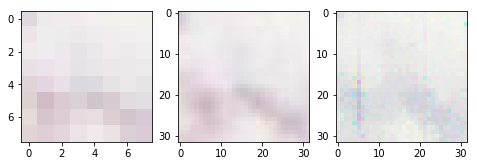

In [8]:
_predict_ith(1724)

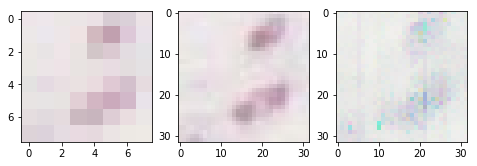

In [9]:
_predict_ith(1423)

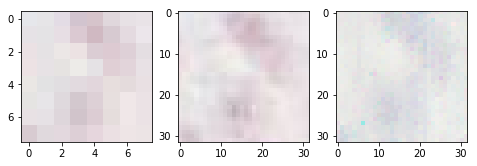

In [10]:
_predict_ith(2142)

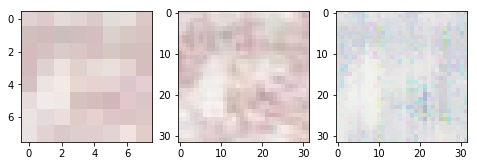

In [11]:
_predict_ith(2142)

In [6]:
ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/allen-ngpu8/allen-ngpu8-j0831-1531-472a/model.ckpt-9137"

INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-09-06 14:51:30,027] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-09-06 14:51:30,031] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-09-06 14:51:30,034] Building model body


INFO:tensorflow:Transforming body output with identity_modality.top


[2018-09-06 14:51:31,896] Transforming body output with identity_modality.top


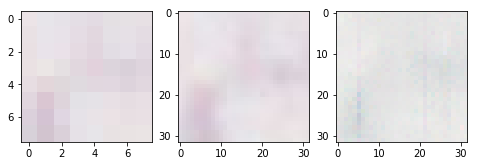

In [9]:
_predict_ith(1724)

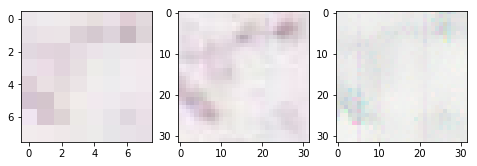

In [11]:
_predict_ith(1724)

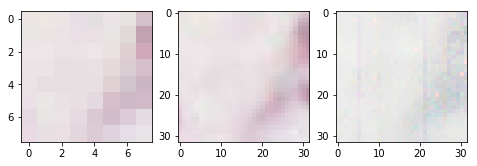

In [20]:
_predict_ith(1724)

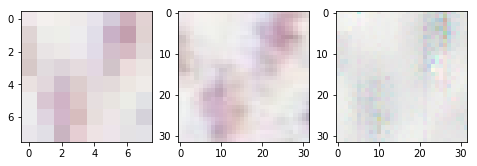

In [21]:
_predict_ith(1724)

INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-09-09 16:01:03,141] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-09-09 16:01:03,334] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-09-09 16:01:10,196] Finished loading event data for comparison.


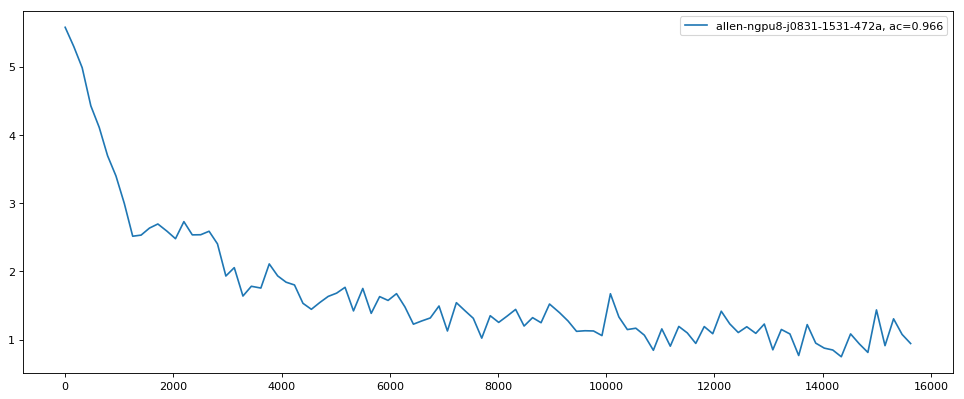

In [42]:
experiment_data = _event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/allen-ngpu8*")
show_experiment_loss(experiment_data)

#### Large image inference

So we still want to improve our model when applied to single patches but we might first be interested in keeping connected with the outcome of up-sampling the resolution of large images, not just small ones. So let's take a shot at that and see what we learn.

In [ ]:
# First let's obtain a large target and downsampled input image from the raw data.
from tensor2tensor.data_generators import image_utils

def get_and_downsample_images(img, size, h_index, v_index, target_dim):

    h_offset = h_index * size
    h_end = h_offset + size - 1

    v_offset = v_index * size
    v_end = v_offset + size - 1

    target_image = np.uint8(img[h_offset:h_end, v_offset:v_end])

    input_image = image_utils.resize_by_area(target_image, target_dim).numpy()
    
    return input_image, target_image

# Now let's obtain a full-size image
!wget http://api.brain-map.org/api/v2/image_download/102173175 \
    -O /tmp/example.jpg

img = Image.open("/tmp/example.jpg")
img = np.float32(img)

input_image, target_image = get_and_downsample_images(img, 512, 4, 10, 128)

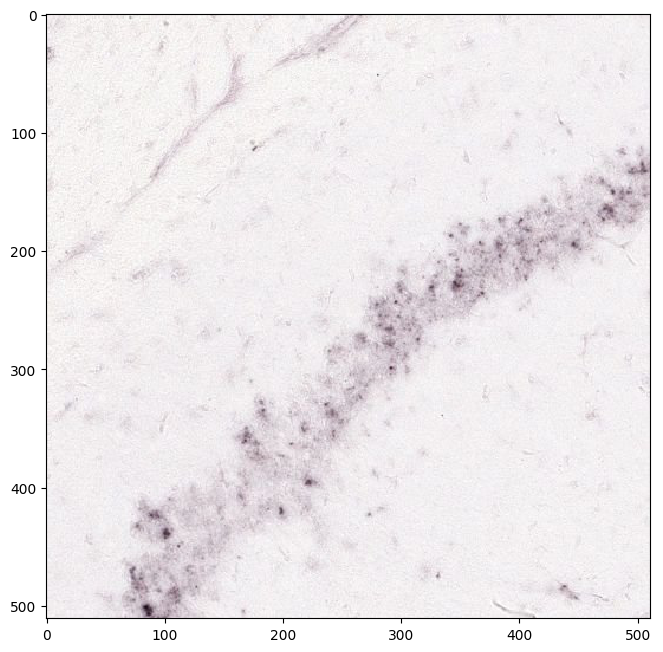

In [14]:
# Here's the target image

plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(target_image)

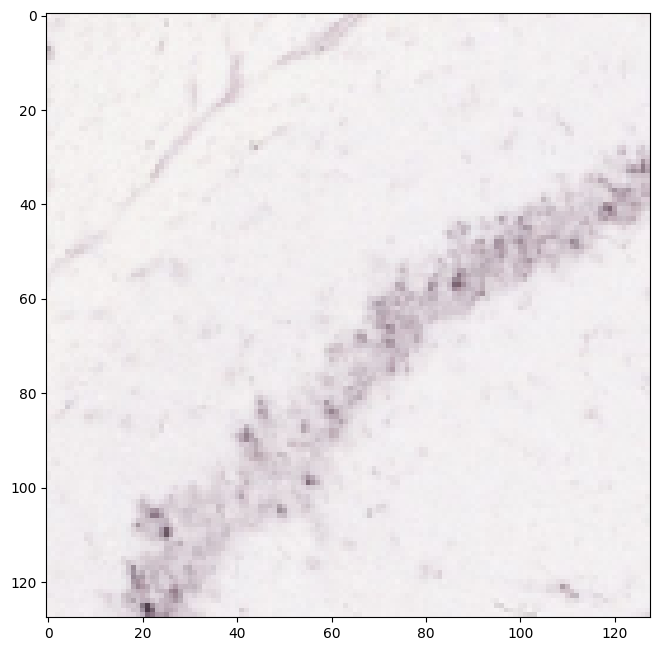

In [15]:
# And the input image

plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(input_image)

INFO:tensorflow:processing row 0 of 16


[2018-08-31 18:34:16,741] processing row 0 of 16


INFO:tensorflow:processing row 1 of 16


[2018-08-31 18:34:33,180] processing row 1 of 16


INFO:tensorflow:processing row 2 of 16


[2018-08-31 18:34:49,360] processing row 2 of 16


INFO:tensorflow:processing row 3 of 16


[2018-08-31 18:35:05,564] processing row 3 of 16


INFO:tensorflow:processing row 4 of 16


[2018-08-31 18:35:21,980] processing row 4 of 16


INFO:tensorflow:processing row 5 of 16


[2018-08-31 18:35:38,387] processing row 5 of 16


INFO:tensorflow:processing row 6 of 16


[2018-08-31 18:35:56,529] processing row 6 of 16


INFO:tensorflow:processing row 7 of 16


[2018-08-31 18:36:12,944] processing row 7 of 16


INFO:tensorflow:processing row 8 of 16


[2018-08-31 18:36:29,290] processing row 8 of 16


INFO:tensorflow:processing row 9 of 16


[2018-08-31 18:36:45,596] processing row 9 of 16


INFO:tensorflow:processing row 10 of 16


[2018-08-31 18:37:02,079] processing row 10 of 16


INFO:tensorflow:processing row 11 of 16


[2018-08-31 18:37:18,319] processing row 11 of 16


INFO:tensorflow:processing row 12 of 16


[2018-08-31 18:37:34,615] processing row 12 of 16


INFO:tensorflow:processing row 13 of 16


[2018-08-31 18:37:51,054] processing row 13 of 16


INFO:tensorflow:processing row 14 of 16


[2018-08-31 18:38:08,981] processing row 14 of 16


INFO:tensorflow:processing row 15 of 16


[2018-08-31 18:38:26,609] processing row 15 of 16


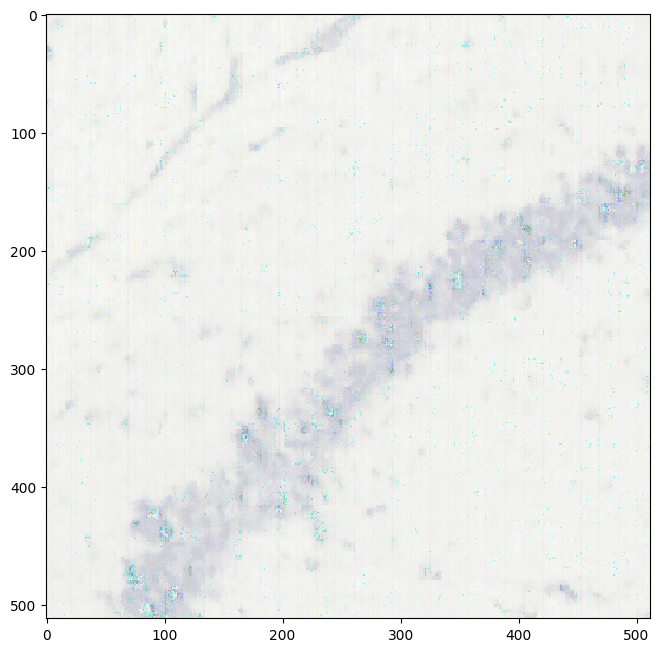

In [28]:
# Now let's employ a naive patchwise up-sampling procedure to produce one large
# up-sampled image.

inferred = patchwise_infer(input_image, ckpt_path, (512, 512, 3))
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(inferred)

Hmm. Very slow, the patches have distinct edges between them, the color is off, and overall it's a bit blurry still.

If we wanted to improve this we might take a look at improving our loss function or boosting the capacity of our models - this result came with a training loss curve that flattened out about 80% less than where it started. We can interpret that as there still being benefit to obtain from this loss measure.

If we were serious about building a large image up-sampler, we would re-formulate the problem to use content already inferred at the top and left boundaries.

##### Large inference with more training

INFO:tensorflow:processing row 0 of 16


[2018-09-06 14:53:04,128] processing row 0 of 16


INFO:tensorflow:processing row 1 of 16


[2018-09-06 14:53:21,199] processing row 1 of 16


INFO:tensorflow:processing row 2 of 16


[2018-09-06 14:53:38,161] processing row 2 of 16


INFO:tensorflow:processing row 3 of 16


[2018-09-06 14:53:55,076] processing row 3 of 16


INFO:tensorflow:processing row 4 of 16


[2018-09-06 14:54:12,350] processing row 4 of 16


INFO:tensorflow:processing row 5 of 16


[2018-09-06 14:54:29,358] processing row 5 of 16


INFO:tensorflow:processing row 6 of 16


[2018-09-06 14:54:46,631] processing row 6 of 16


INFO:tensorflow:processing row 7 of 16


[2018-09-06 14:55:07,037] processing row 7 of 16


INFO:tensorflow:processing row 8 of 16


[2018-09-06 14:55:24,508] processing row 8 of 16


INFO:tensorflow:processing row 9 of 16


[2018-09-06 14:55:42,609] processing row 9 of 16


INFO:tensorflow:processing row 10 of 16


[2018-09-06 14:56:00,376] processing row 10 of 16


INFO:tensorflow:processing row 11 of 16


[2018-09-06 14:56:19,223] processing row 11 of 16


INFO:tensorflow:processing row 12 of 16


[2018-09-06 14:56:36,512] processing row 12 of 16


INFO:tensorflow:processing row 13 of 16


[2018-09-06 14:56:53,882] processing row 13 of 16


INFO:tensorflow:processing row 14 of 16


[2018-09-06 14:57:11,067] processing row 14 of 16


INFO:tensorflow:processing row 15 of 16


[2018-09-06 14:57:28,347] processing row 15 of 16


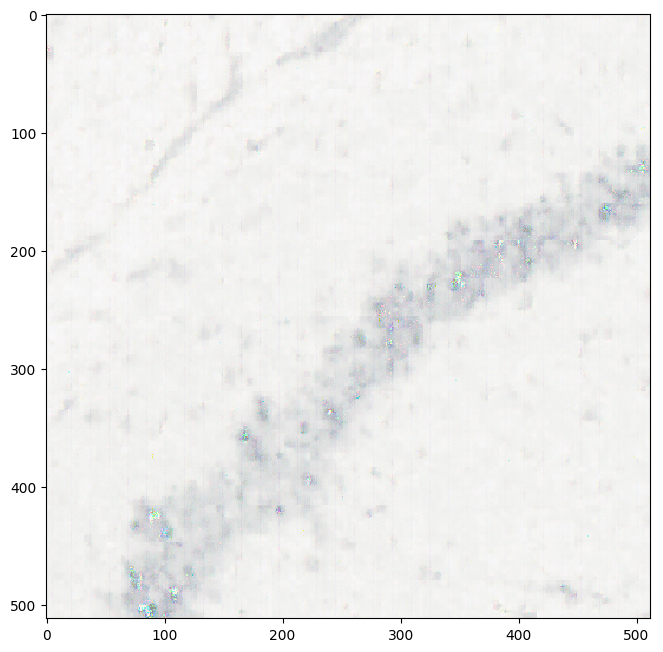

In [16]:
# With ~10k steps

inferred = patchwise_infer(input_image, ckpt_path, (512, 512, 3))
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(inferred)

Some observations:
* The overall color is improved, more grey than teal, but still not overall pink.
* Frequency of teal distortions in dark (nuclear?) regions is reduced.

INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-09-09 16:05:08,499] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 6)


[2018-09-09 16:05:08,707] Processing experiment events (1 of 6)


INFO:tensorflow:Processing experiment events (2 of 6)


[2018-09-09 16:05:16,798] Processing experiment events (2 of 6)


INFO:tensorflow:Processing experiment events (3 of 6)


[2018-09-09 16:05:23,080] Processing experiment events (3 of 6)


INFO:tensorflow:Processing experiment events (4 of 6)


[2018-09-09 16:05:24,100] Processing experiment events (4 of 6)


INFO:tensorflow:Processing experiment events (5 of 6)


[2018-09-09 16:05:25,293] Processing experiment events (5 of 6)


INFO:tensorflow:Processing experiment events (6 of 6)


[2018-09-09 16:05:32,105] Processing experiment events (6 of 6)


INFO:tensorflow:Finished loading event data for comparison.


[2018-09-09 16:05:38,972] Finished loading event data for comparison.


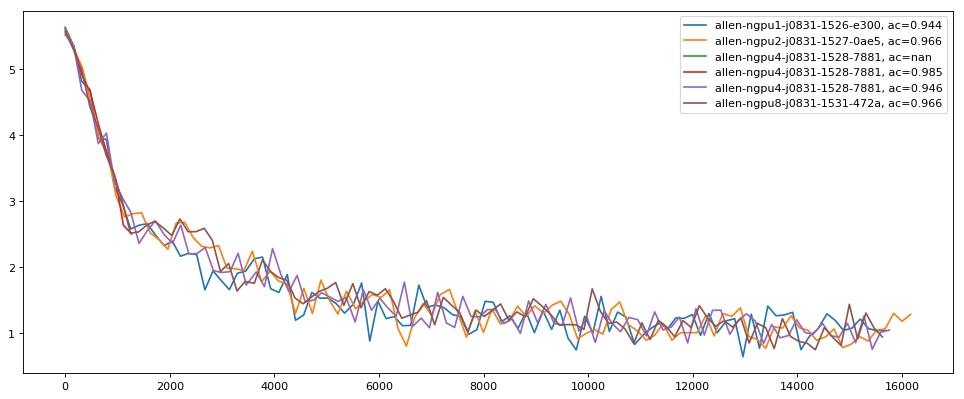

In [45]:
experiment_data = _event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/allen-ngpu*")
show_experiment_loss(experiment_data)

#### Scaling the effective batch size with distributed training

Let's see how we can improve the performance of up-sampling within individual patches.

Given the memory limits of our GPUs (in this case some free K80s) we can only push our effective batch size so high within a single machine (i.e. the per-GPU batch size times the number of GPUs). So if we want to further increase our batch size we're going to have to distribute training over more machines. As in our previous discussion, we'll be looking to see an improvement in the stability of training with an increase in the batch size. But since we're introducing distribution into the mix, we'll be curious how this affects our training speed.

Here are the tensor2tensor docs on [distributed training](https://tensorflow.github.io/tensor2tensor/distributed_training.html).

Notes

* Why does it say "node didn't trigger scale up" and still end up running?
* 1x GPU jobs take a long time to start up after showing the above, 4x GPU jobs show the above for a long time and never start up.


In [53]:
bsize = 18

num_ps = 3 # Use 3 single-gpu parameter servers (as workers).

ps_gpu = 1

problem_name = "img2img_allen_brain_dim8to32"

args = _configure_experiment("allen-dist-ps%s-gpu%s-b%s" % (
                                    num_ps, ps_gpu, bsize),
                             problem=problem_name,
                             num_gpu_per_worker=1,
                             batch_size=bsize,
                             num_steps=20000,
                             num_workers=0,
                             num_ps=num_ps,
                             ps_gpu=ps_gpu)

job = experiment.T2TExperiment(**args)

job.run()

[2018-09-09 16:18:22,556] /mnt/nfs-east1-d/work/tk
[2018-09-09 16:18:22,614] /mnt/nfs-east1-d/work/tk
[2018-09-09 16:20:10,454] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-09-09 18:17:15,807] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-09-09 18:17:16,023] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-09-09 18:17:19,265] Finished loading event data for comparison.


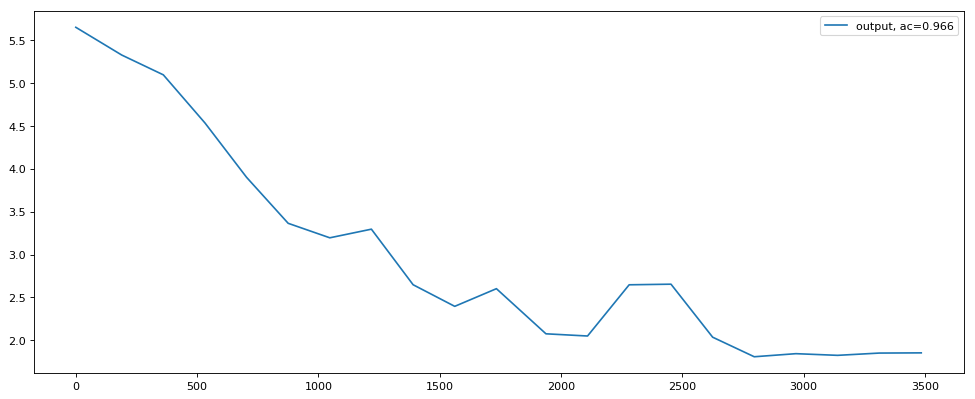

In [71]:
experiment_data = _event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/allen-dist-ps3-gpu1*")
show_experiment_loss(experiment_data)

In [58]:
# Again, spinning up new nodes takes a minute in part because NVIDIA drivers need to be
# installed. When the nodes are up you'll see something like the following.

!kubectl get nodes

NAME                                                  STATUS    ROLES     AGE       VERSION
gke-kubeflow-default-pool-ac9e77b1-g6v4               Ready     <none>    95d       v1.9.6-gke.1
gke-kubeflow-default-pool-ac9e77b1-svsl               Ready     <none>    95d       v1.9.6-gke.1
gke-kubeflow-train-gpu-preemptible-1x-976d4c0c-hsjf   Ready     <none>    22h       v1.9.6-gke.1
gke-kubeflow-train-gpu-preemptible-1x-976d4c0c-j724   Ready     <none>    1h        v1.9.6-gke.1
gke-kubeflow-train-gpu-preemptible-1x-976d4c0c-s4gp   Ready     <none>    1h        v1.9.6-gke.1
gke-kubeflow-train-gpu-preemptible-1x-976d4c0c-tm3d   Ready     <none>    1h        v1.9.6-gke.1


In [59]:
# We can list our pods for the job as follows

!kubectl get pods -n kubeflow | grep dist

allen-dist-ps3-gpu1-b18-j0909-1618-580b-master-qdhj-0-tsbqt   1/1       Running            0          1h
allen-dist-ps3-gpu1-b18-j0909-1618-580b-ps-qdhj-0-1s6bi       1/1       Running            0          1h
allen-dist-ps3-gpu1-b18-j0909-1618-580b-ps-qdhj-1-ebdlz       1/1       Running            0          1h
allen-dist-ps3-gpu1-b18-j0909-1618-580b-ps-qdhj-2-f2df4       1/1       Running            0          1h


In [65]:
# As the master starts up and waits for each worker to be ready you'll see something like this

!kubectl logs -n kubeflow allen-dist-ps3-gpu1-b18-j0909-1618-580b-master-qdhj-0-tsbqt | tail -n 75 | head -n 40

2018-09-09 16:38:33.694686: I tensorflow/core/distributed_runtime/master.cc:224] CreateSession still waiting for response from worker: /job:ps/replica:0/task:1
2018-09-09 16:38:43.694866: I tensorflow/core/distributed_runtime/master.cc:224] CreateSession still waiting for response from worker: /job:ps/replica:0/task:1
2018-09-09 16:38:53.695018: I tensorflow/core/distributed_runtime/master.cc:224] CreateSession still waiting for response from worker: /job:ps/replica:0/task:1
2018-09-09 16:39:03.695223: I tensorflow/core/distributed_runtime/master.cc:224] CreateSession still waiting for response from worker: /job:ps/replica:0/task:1
2018-09-09 16:39:13.695388: I tensorflow/core/distributed_runtime/master.cc:224] CreateSession still waiting for response from worker: /job:ps/replica:0/task:1
2018-09-09 16:39:23.695520: I tensorflow/core/distributed_runtime/master.cc:224] CreateSession still waiting for response from worker: /job:ps/replica:0/task:1
2018-09-09 16:39:33.695778: I tensorflow

Worker startup has succeeded if they reach the line "Started server with target: grpc://...", such as the following. Once all workers have reached this point, logs on the master should no longer show CreateSession errors and proceed with training as shown above.

In [67]:
!kubectl logs -n kubeflow allen-dist-ps3-gpu1-b18-j0909-1618-580b-ps-qdhj-0-1s6bi | tail -n 25

  }
}
, 'use_tpu': False, '_tf_random_seed': None, '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': u'grpc://allen-dist-ps3-gpu1-b18-j0909-1618-580b-master-qdhj-0:2222', 't2t_device_info': {'num_async_replicas': 1}, '_num_ps_replicas': 3, '_train_distribute': None, '_is_chief': False, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_save_checkpoints_steps': None, '_environment': u'cloud', '_master': u'grpc://allen-dist-ps3-gpu1-b18-j0909-1618-580b-master-qdhj-0:2222', '_model_dir': 'gs://kubeflow-rl-checkpoints/comparisons/allen-dist-ps3-gpu1-b18/allen-dist-ps3-gpu1-b18-j0909-1618-580b/output', 'data_parallelism': <tensor2tensor.utils.expert_utils.Parallelism object at 0x7f94f0c8bc50>, '_save_summary_steps': 100}
Instructions for updating:
Please switch to tf.estimator.train_and_evaluate. You will also have to convert to a tf.estimator.Estimator.
2018-09-09 16:22:57.107684: I tensorflow/core/platfo

We won't do too much with distributed training here since currently my setup isn't liking distributed jobs with more than one GPU per worker or more than four nodes per job but stay tuned.

### Logs from non-existing pods

In [ ]:
!gcloud logging --project kubeflow-rl read "resource.labels.pod_id=allen-retainslogs-j0909-1806-5746-master-n3ou-0-eygj3" --format json --order asc | grep textPayload | sed 's/": "/@/g' | cut -f2 -d'@'

### Per-image standardization

What happens when we apply per-image standardization?

In [109]:
# Does it run at all?

problem_name = "img2img_allen_brain_dim8to32_stnd"

bsize = 1

args = _configure_experiment("allen-stnd2-8to32-b%s" % bsize,
                             problem=problem_name,
                             num_gpu_per_worker=1,
                             batch_size=bsize,
                             num_steps=10000)

job = experiment.T2TExperiment(**args)

job.run()


[2018-09-09 19:58:49,829] /mnt/nfs-east1-d/work/tk
[2018-09-09 19:58:49,839] /mnt/nfs-east1-d/work/tk
[2018-09-09 20:00:34,536] smoke: True


In [ ]:
# Runs through 100 steps, 10k run in progress
allen-stnd2-8to32-b1-j0909-1958-239d-master-a2lz-0-990ad

In [ ]:
!gcloud logging --project kubeflow-rl read "resource.labels.pod_id=allen-stnd-8to32-b1-j0909-1904-e920-master-se2n-0-8vbyt" --format json --order asc | grep textPayload | sed 's/": "/@/g' | cut -f2 -d'@'

INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-09-09 21:56:44,725] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-09-09 21:56:44,938] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-09-09 21:56:51,819] Finished loading event data for comparison.


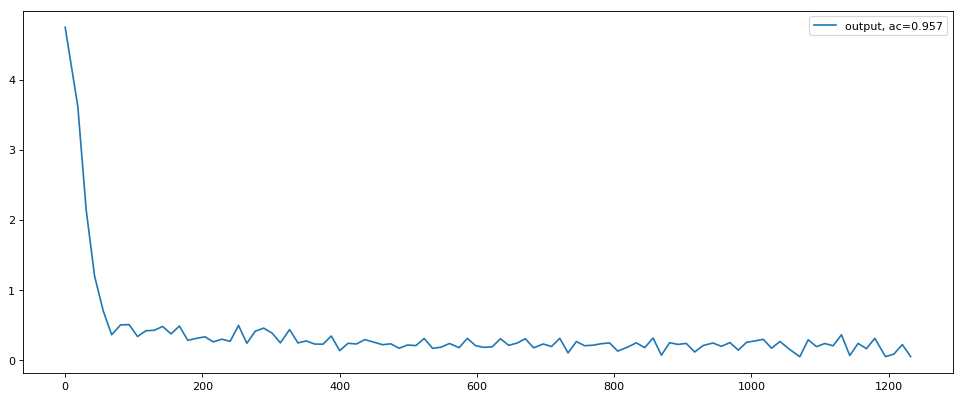

In [117]:
experiment_data = _event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/allen-stnd2-8to32-b1*")
show_experiment_loss(experiment_data)

In [ ]:
# That doesn't look right.

### Adversarial loss

So we've been through the paces with the standard approaches and it seems to be time to break out the bass cannon. Let's try adding an adversarial loss.

In [108]:
bsize = 1

args = _configure_experiment("allen-adv-8to32-b%s" % bsize,
                             model="img2img_transformer_adversarial",
                             problem="img2img_allen_brain_dim8to32",
                             hparams_set="img2img_transformer_2d_adversarial",
                             num_gpu_per_worker=1,
                             batch_size=bsize,
                             num_steps=10000)

job = experiment.T2TExperiment(**args)

job.run()


[2018-09-09 19:56:46,665] /mnt/nfs-east1-d/work/tk
[2018-09-09 19:56:46,684] /mnt/nfs-east1-d/work/tk
[2018-09-09 19:58:37,060] smoke: True


In [ ]:
# Ran through step 100 without error, 10k run in progress.
allen-adv-8to32-b1-j0909-1956-5f6f-master-p6fe-0-f8j4r

In [ ]:

!gcloud logging --project kubeflow-rl read "resource.labels.pod_id=allen-adv-8to32-b1-j0909-1949-32a4-master-b9p1-0-xfpvt" --format json --order asc | grep textPayload | sed 's/": "/@/g' | cut -f2 -d'@'


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-09-09 21:57:55,839] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 2)


[2018-09-09 21:57:56,056] Processing experiment events (1 of 2)


INFO:tensorflow:Processing experiment events (2 of 2)


[2018-09-09 21:57:56,700] Processing experiment events (2 of 2)


INFO:tensorflow:Finished loading event data for comparison.


[2018-09-09 21:58:00,870] Finished loading event data for comparison.


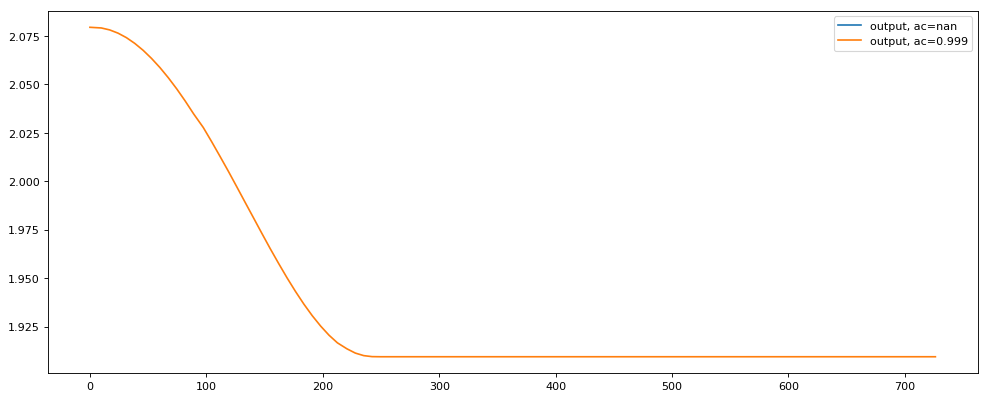

In [118]:
experiment_data = _event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/allen-adv-8to32*")
show_experiment_loss(experiment_data)

In [ ]:
# That's overly smooth, probably something is wrong with the loss function.

### Smaller up-sampling ratio

#### 24 to 32

In [ ]:
# Search for the max trainable batch size

for bsize in [1, 4, 8, 16, 18]:
    args = _configure_experiment("allen-24to32-b%s" % bsize,
                                 problem="img2img_allen_brain_dim24to32",
                                 num_gpu_per_worker=1,
                                 batch_size=bsize,
                                 num_steps=100)
    job = experiment.T2TExperiment(**args)
    job.run()


In [ ]:

!gcloud logging --project kubeflow-rl read "resource.labels.pod_id=allen-24to32-b1-j0909-1914-7cd7-master-gfzr-0-rf8oc" --format json --order asc | grep textPayload | sed 's/": "/@/g' | cut -f2 -d'@'


In [103]:
!gsutil ls gs://kubeflow-rl-checkpoints/comparisons/allen-24to32*/*/output | grep ckpt-100.meta

gs://kubeflow-rl-checkpoints/comparisons/allen-24to32-b1/allen-24to32-b1-j0909-1914-7cd7/output/model.ckpt-100.meta
gs://kubeflow-rl-checkpoints/comparisons/allen-24to32-b10/allen-24to32-b10-j0909-1934-aa8d/output/model.ckpt-100.meta
gs://kubeflow-rl-checkpoints/comparisons/allen-24to32-b11/allen-24to32-b11-j0909-1936-904e/output/model.ckpt-100.meta
gs://kubeflow-rl-checkpoints/comparisons/allen-24to32-b4/allen-24to32-b4-j0909-1916-4674/output/model.ckpt-100.meta
gs://kubeflow-rl-checkpoints/comparisons/allen-24to32-b8/allen-24to32-b8-j0909-1918-4ef6/output/model.ckpt-100.meta
gs://kubeflow-rl-checkpoints/comparisons/allen-24to32-b9/allen-24to32-b9-j0909-1932-63cf/output/model.ckpt-100.meta


In [ ]:
# Search for the max trainable batch size

for bsize in [9, 10, 11, 12, 13, 14, 15]:
    args = _configure_experiment("allen-24to32-b%s" % bsize,
                                 problem="img2img_allen_brain_dim24to32",
                                 num_gpu_per_worker=1,
                                 batch_size=bsize,
                                 num_steps=100)
    job = experiment.T2TExperiment(**args)
    job.run()


In [104]:
!gsutil ls gs://kubeflow-rl-checkpoints/comparisons/allen-24to32*/*/output | grep ckpt-100.meta

gs://kubeflow-rl-checkpoints/comparisons/allen-24to32-b1/allen-24to32-b1-j0909-1914-7cd7/output/model.ckpt-100.meta
gs://kubeflow-rl-checkpoints/comparisons/allen-24to32-b10/allen-24to32-b10-j0909-1934-aa8d/output/model.ckpt-100.meta
gs://kubeflow-rl-checkpoints/comparisons/allen-24to32-b11/allen-24to32-b11-j0909-1936-904e/output/model.ckpt-100.meta
gs://kubeflow-rl-checkpoints/comparisons/allen-24to32-b4/allen-24to32-b4-j0909-1916-4674/output/model.ckpt-100.meta
gs://kubeflow-rl-checkpoints/comparisons/allen-24to32-b8/allen-24to32-b8-j0909-1918-4ef6/output/model.ckpt-100.meta
gs://kubeflow-rl-checkpoints/comparisons/allen-24to32-b9/allen-24to32-b9-j0909-1932-63cf/output/model.ckpt-100.meta


Looks like a batch size of 11 is the largest that runs without failure, let's use that.

In [105]:

bsize = 11

args = _configure_experiment("allen-24to32-b%s" % bsize,
                             problem="img2img_allen_brain_dim24to32",
                             num_gpu_per_worker=1,
                             batch_size=bsize,
                             num_steps=15000)
job = experiment.T2TExperiment(**args)
job.run()


[2018-09-09 19:53:32,842] /mnt/nfs-east1-d/work/tk
[2018-09-09 19:53:32,851] /mnt/nfs-east1-d/work/tk
[2018-09-09 19:55:14,311] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-09-09 21:59:13,330] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 2)


[2018-09-09 21:59:13,582] Processing experiment events (1 of 2)


INFO:tensorflow:Processing experiment events (2 of 2)


[2018-09-09 21:59:15,772] Processing experiment events (2 of 2)


INFO:tensorflow:Finished loading event data for comparison.


[2018-09-09 21:59:20,290] Finished loading event data for comparison.


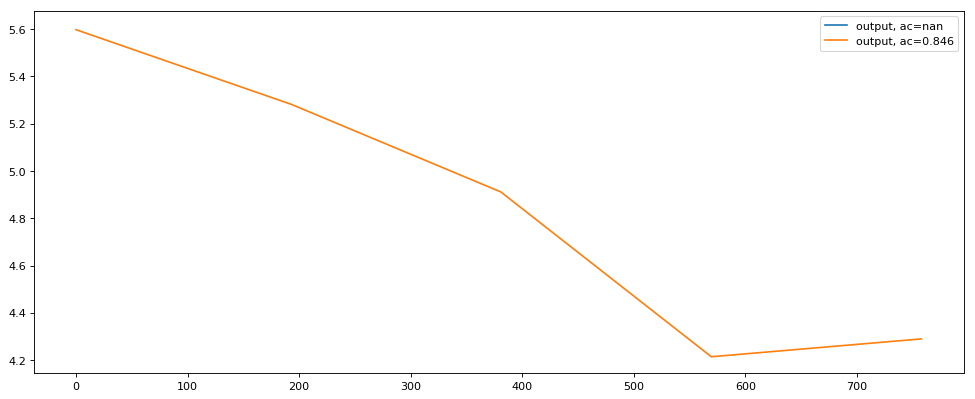

In [119]:
experiment_data = _event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/allen-24to32-b11*")
show_experiment_loss(experiment_data)

In [125]:

# Looks like we ran out of GPU memory, let's re-try with a smaller batch size.
!gcloud logging --project kubeflow-rl read "resource.labels.pod_id=allen-24to32-b11-j0909-1953-5a50-master-1h7e-0-8ozdk" --format json --order asc | grep textPayload | sed 's/": "/@/g' | cut -f2 -d'@' | head -n 380 | tail -n 50


INFO:tensorflow:loss = 5.597764, step = 0\n",
INFO:tensorflow:global_step/sec: 0.520039\n",
INFO:tensorflow:loss = 5.2813997, step = 100 (193.262 sec)\n",
INFO:tensorflow:global_step/sec: 0.534713\n",
INFO:tensorflow:loss = 4.9114203, step = 200 (187.485 sec)\n",
INFO:tensorflow:global_step/sec: 0.533903\n",
INFO:tensorflow:loss = 4.214163, step = 300 (188.636 sec)\n",
INFO:tensorflow:global_step/sec: 0.529552\n",
INFO:tensorflow:loss = 4.2896905, step = 400 (188.281 sec)\n",
INFO:tensorflow:global_step/sec: 0.53175\n",
INFO:tensorflow:loss = 3.5836253, step = 500 (188.185 sec)\n",
2018-09-09 20:18:12.125356: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.30GiB.  Current allocation summary follows.\n",
2018-09-09 20:18:12.125469: I tensorflow/core/common_runtime/bfc_allocator.cc:630] Bin (256): \tTotal Chunks: 156, Chunks in use: 154. 39.0KiB allocated for chunks. 38.5KiB in use in bin. 644B client-requested in use in

In [126]:
for bsize in [9, 10]:
    args = _configure_experiment("allen-24to32-b%s" % bsize,
                                 problem="img2img_allen_brain_dim24to32",
                                 num_gpu_per_worker=1,
                                 batch_size=bsize,
                                 num_steps=10000)
    job = experiment.T2TExperiment(**args)
    job.run()

[2018-09-09 22:04:35,084] /mnt/nfs-east1-d/work/tk
[2018-09-09 22:04:35,132] /mnt/nfs-east1-d/work/tk
[2018-09-09 22:06:22,791] smoke: True
[2018-09-09 22:06:22,926] /mnt/nfs-east1-d/work/tk
[2018-09-09 22:06:22,939] /mnt/nfs-east1-d/work/tk
[2018-09-09 22:08:12,146] smoke: True


#### That's all for now!

In [ ]:
# Why can we only run four jobs at a time?

# Transition over to shipping code via containers when appropriate.

# Tried the 48 to 64 problem, all batch sizes crashed so going to skip that one.

I'll note that a good next direction for this would be to experiment with an adversarial loss or a mixture of adversarial and what we're using here. So far those experiments haven't panned out but maybe that's good material for a future post.

In-painting might also be a good direction to explore.

If you're interested in getting started with Kubeflow be sure to check out [kubeflow/examples](https://github.com/kubeflow/examples).